In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

- https://www.youtube.com/watch?v=ElmBrKyMXxs
- https://github.com/hans/ipython-notebooks/blob/master/tf/TF%20tutorial.ipynb
- https://github.com/ematvey/tensorflow-seq2seq-tutorials

In [2]:
from __future__ import division
import tensorflow as tf
from os import path, remove
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import StratifiedShuffleSplit
from time import time
from matplotlib import pyplot as plt
import seaborn as sns
from mylibs.jupyter_notebook_helper import show_graph, renderStatsList, renderStatsCollection, \
    renderStatsListWithLabels, renderStatsCollectionOfCrossValids, plot_res_gp, my_plot_convergence
from tensorflow.contrib import rnn
from tensorflow.contrib import learn
import shutil
from tensorflow.contrib.learn.python.learn import learn_runner
from mylibs.tf_helper import getDefaultGPUconfig
from sklearn.metrics import r2_score
from mylibs.py_helper import factors
from fastdtw import fastdtw
from collections import OrderedDict
from scipy.spatial.distance import euclidean
from statsmodels.tsa.stattools import coint
from common import get_or_run_nn
from data_providers.price_history_seq2seq_data_provider import PriceHistorySeq2SeqDataProvider
from data_providers.price_history_dataset_generator import PriceHistoryDatasetGenerator
from skopt.space.space import Integer, Real
from skopt import gp_minimize
from skopt.plots import plot_convergence
import pickle
import inspect
import dill
import sys
from models.price_history_21_seq2seq_dyn_dec_ins import PriceHistorySeq2SeqDynDecIns
from gp_opt.price_history_23_gp_opt import PriceHistory23GpOpt

/home/studenthp/anaconda2/envs/dis/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


ImportError: No module named price_history_21_seq2seq_dyn_dec_ins

In [ ]:
dtype = tf.float32
seed = 16011984
random_state = np.random.RandomState(seed=seed)
config = getDefaultGPUconfig()
n_jobs = 1
%matplotlib inline

### Step 0 - hyperparams

vocab_size is all the potential words you could have (classification for translation case)
and max sequence length are the SAME thing

decoder RNN hidden units are usually same size as encoder RNN hidden units in translation but for our case it does not seem really to be a relationship there but we can experiment and find out later, not a priority thing right now

In [ ]:
num_units = 400 #state size

input_len = 60
target_len = 30

batch_size = 64 #50
with_EOS = False

In [ ]:
total_train_size = 57994
train_size = 6400 
test_size = 1282

### Once generate data

In [ ]:
data_path = '../data/price_history'

In [ ]:
#npz_full_train = data_path + '/price_history_03_dp_60to30_train.npz'
#npz_full_train = data_path + '/price_history_60to30_targets_normed_train.npz'
npz_full_train = data_path + '/price_history_03_dp_60to30_global_remove_scale_targets_normed_train.npz'

#npz_train = data_path + '/price_history_03_dp_60to30_57980_train.npz'
#npz_train = data_path + '/price_history_03_dp_60to30_6400_train.npz'
#npz_train = data_path + '/price_history_60to30_6400_targets_normed_train.npz'
npz_train = data_path + '/price_history_03_dp_60to30_6400_global_remove_scale_targets_normed_train.npz'

#npz_test = data_path + '/price_history_03_dp_60to30_test.npz'
#npz_test = data_path + '/price_history_60to30_targets_normed_test.npz'
npz_test = data_path + '/price_history_03_dp_60to30_global_remove_scale_targets_normed_test.npz'

### Step 1 - collect data

In [ ]:
# dp = PriceHistorySeq2SeqDataProvider(npz_path=npz_train, batch_size=batch_size, with_EOS=with_EOS)
# dp.inputs.shape, dp.targets.shape

In [ ]:
# aa, bb = dp.next()
# aa.shape, bb.shape

### Step 2 - Build model

In [ ]:
model = PriceHistorySeq2SeqDynDecIns(rng=random_state, dtype=dtype, config=config, with_EOS=with_EOS)

In [ ]:
# graph = model.getGraph(batch_size=batch_size,
#                        num_units=num_units,
#                        input_len=input_len,
#                        target_len=target_len)

In [ ]:
#show_graph(graph)

# Cross Validating

In [13]:
def plotter(stats_list, label_text):
    _ = renderStatsListWithLabels(stats_list=stats_list, label_text=label_text)
    plt.show()

    _ = renderStatsListWithLabels(stats_list=stats_list, label_text=label_text,
                                  title='Validation Error', kk='error(valid)')
    plt.show()

In [14]:
#sorted(factors(6400))

In [15]:
obj = PriceHistory23GpOpt(model=model,
                          stats_npy_filename = 'bayes_opt_23_stats_dic',
                          cv_score_dict_npy_filename = 'bayes_opt_23_cv_scores_dic',
                          random_state=random_state,
                          plotter = plotter,
                          npz_path=npz_train,
                          epochs=15,
                          batch_size=batch_size,
                          input_len=input_len,
                          target_len=target_len,
                          n_splits=5,
                         )

In [16]:
opt_res = obj.run_opt(n_random_starts=2, n_calls=17)

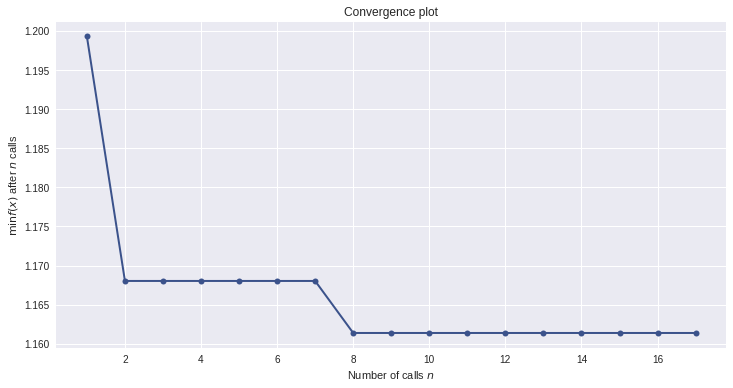

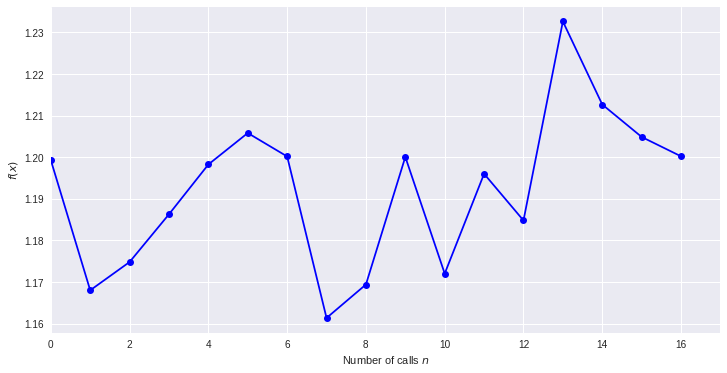

In [17]:
plot_res_gp(opt_res)

In [18]:
opt_res.best_params

[500,
 <function tensorflow.python.ops.math_ops.tanh>,
 0.0001,
 0.62488034788862112,
 0.001]

In [19]:
filepath = PriceHistory23GpOpt.bayes_opt_dir + '/bayes_opt_23_stats_dic.npy'

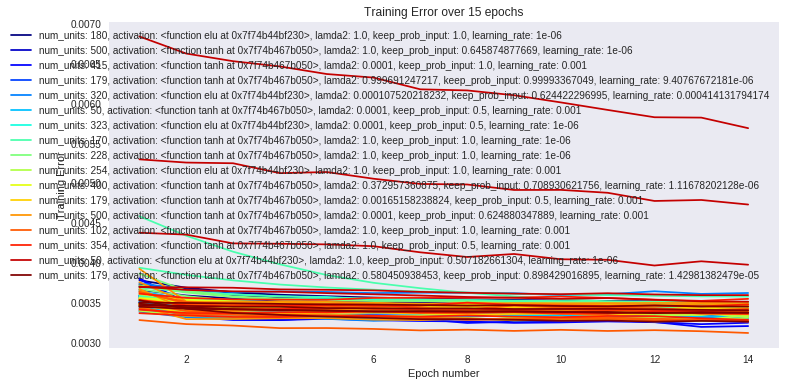

In [20]:
renderStatsCollectionOfCrossValids(stats_dic=np.load(filepath)[()], label_texts=[
    'num_units', 'activation', 'lamda2', 'keep_prob_input', 'learning_rate'])
plt.show()

### Step 3 training the network

In [21]:
model = PriceHistorySeq2SeqDynDecIns(rng=random_state, dtype=dtype, config=config, with_EOS=with_EOS)

In [22]:
opt_res.best_params

[500,
 <function tensorflow.python.ops.math_ops.tanh>,
 0.0001,
 0.62488034788862112,
 0.001]

In [23]:
num_units, activation, lamda2, keep_prob_input, learning_rate = opt_res.best_params

In [24]:
batch_size

64

In [25]:
npz_1280_test = '../data/price_history/price_history_03_dp_60to30_global_remove_scale_targets_normed_1280_test.npz'

In [26]:
# PriceHistoryDatasetGenerator.create_subsampled(inpath=npz_test, target_size=1280,
#     outpath='../data/price_history/price_history_03_dp_60to30_global_remove_scale_targets_normed_1280_test.npz',
#                                               random_state=random_state)

In [49]:
def experiment():
    return model.run(npz_path=npz_train,
             npz_test = npz_1280_test,
             epochs=200,
             batch_size = batch_size,
             num_units = num_units,
             input_len=input_len,
             target_len=target_len,
             learning_rate = learning_rate * 10,
             preds_gather_enabled=True,
             batch_norm_enabled = True,
             activation = activation,
             decoder_first_input = PriceHistorySeq2SeqDynDecIns.DECODER_FIRST_INPUT.ZEROS,
             keep_prob_input = keep_prob_input,
             lamda2 = lamda2,
            )

In [50]:
#%%time
dyn_stats, preds_dict, targets = get_or_run_nn(experiment, filename='023_seq2seq_60to30_001')

epochs: 200
lamda2: 0.0001
learning_rate: 0.01
keep_prob_input: 0.624880347889
num_units: 500
End Epoch 01 (37.182 secs): err(train) = 0.118516, current dec_ins_percent_usage: 1.00
End Epoch 02 (36.169 secs): err(train) = 0.033457, current dec_ins_percent_usage: 0.00
End Epoch 03 (36.203 secs): err(train) = 0.003609, current dec_ins_percent_usage: 0.00
End Epoch 04 (36.283 secs): err(train) = 0.003532, current dec_ins_percent_usage: 0.00
End Epoch 05 (36.170 secs): err(train) = 0.003585, current dec_ins_percent_usage: 0.00
End Epoch 06 (36.241 secs): err(train) = 0.003649, current dec_ins_percent_usage: 0.00
End Epoch 07 (36.219 secs): err(train) = 0.003587, current dec_ins_percent_usage: 0.00
End Epoch 08 (36.213 secs): err(train) = 0.003560, current dec_ins_percent_usage: 0.00
End Epoch 09 (36.171 secs): err(train) = 0.003549, current dec_ins_percent_usage: 0.00
End Epoch 10 (36.275 secs): err(train) = 0.003572, current dec_ins_percent_usage: 0.00
End Epoch 11 (36.233 secs): err(trai

End Epoch 95 (36.169 secs): err(train) = 0.005292, current dec_ins_percent_usage: 0.00
End Epoch 96 (36.299 secs): err(train) = 0.005180, current dec_ins_percent_usage: 0.00
End Epoch 97 (36.205 secs): err(train) = 0.005185, current dec_ins_percent_usage: 0.00
End Epoch 98 (36.184 secs): err(train) = 0.005694, current dec_ins_percent_usage: 0.00
End Epoch 99 (36.212 secs): err(train) = 0.004868, current dec_ins_percent_usage: 0.00
End Epoch 100 (36.226 secs): err(train) = 0.005555, current dec_ins_percent_usage: 0.00
End Epoch 101 (36.155 secs): err(train) = 0.005294, current dec_ins_percent_usage: 0.00
End Epoch 102 (36.195 secs): err(train) = 0.006024, current dec_ins_percent_usage: 0.00
End Epoch 103 (36.241 secs): err(train) = 0.005580, current dec_ins_percent_usage: 0.00
End Epoch 104 (36.226 secs): err(train) = 0.005827, current dec_ins_percent_usage: 0.00
End Epoch 105 (36.230 secs): err(train) = 0.004788, current dec_ins_percent_usage: 0.00
End Epoch 106 (36.238 secs): err(trai

End Epoch 189 (36.270 secs): err(train) = 0.008675, current dec_ins_percent_usage: 0.00
End Epoch 190 (36.185 secs): err(train) = 0.011769, current dec_ins_percent_usage: 0.00
End Epoch 191 (36.187 secs): err(train) = 0.022564, current dec_ins_percent_usage: 0.00
End Epoch 192 (36.196 secs): err(train) = 0.005908, current dec_ins_percent_usage: 0.00
End Epoch 193 (36.211 secs): err(train) = 0.012559, current dec_ins_percent_usage: 0.00
End Epoch 194 (36.165 secs): err(train) = 0.010937, current dec_ins_percent_usage: 0.00
End Epoch 195 (36.189 secs): err(train) = 0.013386, current dec_ins_percent_usage: 0.00
End Epoch 196 (36.253 secs): err(train) = 0.010682, current dec_ins_percent_usage: 0.00
End Epoch 197 (36.212 secs): err(train) = 0.020058, current dec_ins_percent_usage: 0.00
End Epoch 198 (36.188 secs): err(train) = 0.011433, current dec_ins_percent_usage: 0.00
End Epoch 199 (36.191 secs): err(train) = 0.012424, current dec_ins_percent_usage: 0.00
End Epoch 200 (36.181 secs): err

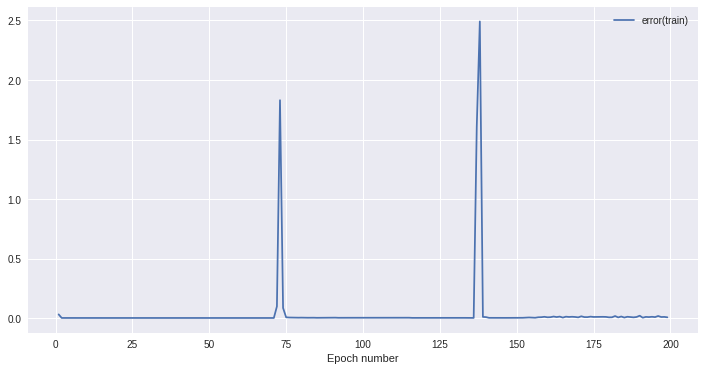

In [51]:
dyn_stats.plotStats()
plt.show()

In [52]:
r2_scores = [r2_score(y_true=targets[ind], y_pred=preds_dict[ind])
            for ind in range(len(targets))]

In [53]:
ind = np.argmin(r2_scores)
ind

982

In [54]:
reals = targets[ind]
preds = preds_dict[ind]

In [55]:
r2_score(y_true=reals, y_pred=preds)

-9.1702243301940658e+31

In [56]:
#sns.tsplot(data=dp.inputs[ind].flatten())

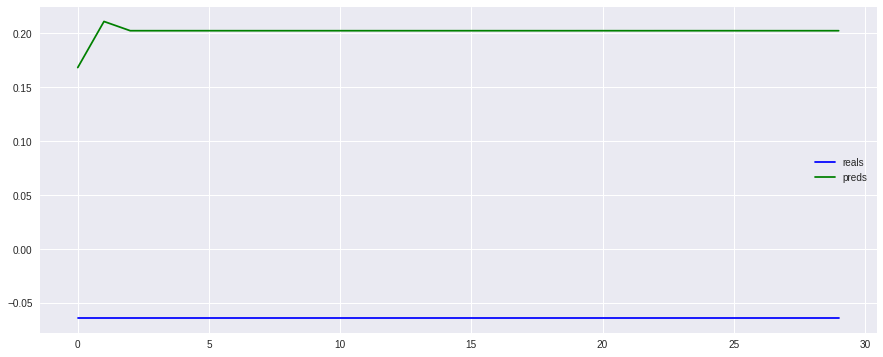

In [57]:
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [58]:
%%time
dtw_scores = [fastdtw(targets[ind], preds_dict[ind])[0]
             for ind in range(len(targets))]

CPU times: user 2.64 s, sys: 24 ms, total: 2.66 s
Wall time: 2.61 s


In [59]:
np.mean(dtw_scores)

6.0055440004832388

In [60]:
coint(preds, reals)

(-0.13411680774304685,
 0.98224889993680475,
 array([-4.31395736, -3.55493606, -3.19393252]))

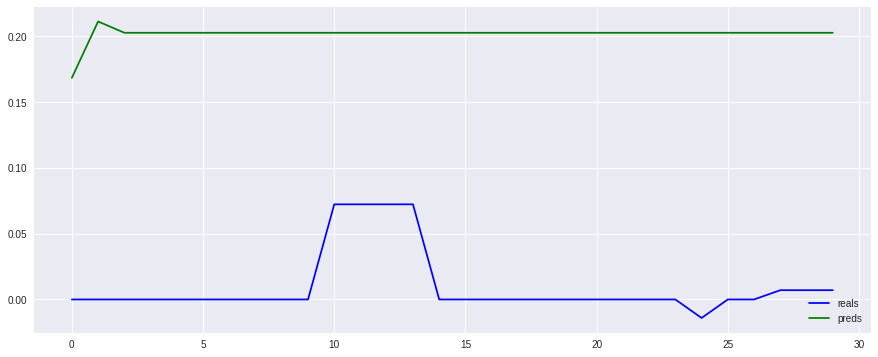

In [187]:
cur_ind = np.random.randint(len(targets))
reals = targets[cur_ind]
preds = preds_dict[cur_ind]
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [189]:
npz_1280_test

'../data/price_history/price_history_03_dp_60to30_global_remove_scale_targets_normed_1280_test.npz'

In [190]:
aa = np.load(npz_1280_test)

In [195]:
len( set(aa['sku_ids']) )

24

### Conclusion
The above test will be considered UNRELIABLE because it represents only 24 cellphones!
We will generate a new test set